In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import os


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [4]:
import os
path_2 = os.path.join(path, "Master Folder")

train_dir = os.path.join(path, "Master Folder", "train")
val_dir = os.path.join(path, "Master Folder", "valid")
test_dir = os.path.join(path, "Master Folder", "test")


In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1, downsample=None):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.downsample = downsample

    def call(self, x, training=False):
        identity = x
        if self.downsample:
            identity = self.downsample(x, training=training)

        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        out += identity
        out = self.relu(out)
        return out


# Build a ResNet layer with n blocks
def make_layer(filters, blocks, stride=1):
    downsample = None
    if stride != 1:
        downsample = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False),
            layers.BatchNormalization()
        ])

    layers_list = [ResidualBlock(filters, stride, downsample)]
    for _ in range(1, blocks):
        layers_list.append(ResidualBlock(filters))

    return tf.keras.Sequential(layers_list)


# ResNet-18 Model
class ResNet18(tf.keras.Model):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.maxpool = layers.MaxPool2D(pool_size=3, strides=2, padding='same')

        self.layer1 = make_layer(64, 2)
        self.layer2 = make_layer(128, 2, stride=2)
        self.layer3 = make_layer(256, 2, stride=2)
        self.layer4 = make_layer(512, 2, stride=2)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        x = self.avgpool(x)
        x = self.fc(x)
        return x

model2 = ResNet18(num_classes=4)


In [35]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)


Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

model2.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.2226 - loss: 1.6665
Epoch 1: val_accuracy improved from -inf to 0.19444, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.2231 - loss: 1.6648 - val_accuracy: 0.1944 - val_loss: 2.1626
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2423 - loss: 1.5117
Epoch 2: val_accuracy improved from 0.19444 to 0.30556, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - accuracy: 0.2421 - loss: 1.5105 - val_accuracy: 0.3056 - val_loss: 1.5464
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.2313 - loss: 1.4300
Epoch 3: val_accuracy did not improve from 0.30556
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.2313 - loss: 1.4296 - val_accuracy: 0.3056 - val_loss: 1.4668
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2580 - loss: 1.4291
Epoch 4: val_accuracy did not improve from 0.30556
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.2575 - loss: 1.4287 - val_accuracy: 0.2500 - val_loss: 1.4567
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.2632 - loss: 1.4231
Epoch 5: val_accuracy did not improve from 0.30556
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.2625 - loss: 1.4228 - val_accuracy: 0.1944 - val_loss: 1.4523
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2168 - loss: 1.4130
Epoch 6: val_accuracy did not i

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.1949 - loss: 1.3683 - val_accuracy: 0.3333 - val_loss: 1.4046
Epoch 33/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.2066 - loss: 1.3775
Epoch 33: val_accuracy did not improve from 0.33333
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step - accuracy: 0.2060 - loss: 1.3772 - val_accuracy: 0.3056 - val_loss: 1.4017
Epoch 34/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.1924 - loss: 1.3654
Epoch 34: val_accuracy did not improve from 0.33333
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - accuracy: 0.1923 - loss: 1.3656 - val_accuracy: 0.3056 - val_loss: 1.4008
Epoch 35/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1748 - loss: 1.3646
Epoch 35: val_accuracy did not improve from 0.33333
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.1750 - loss: 1.3647 - val_accuracy: 0.3056 - val_loss: 1.4002
Epoch 36/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.1935 - loss: 1.3694
Epoch 36: val_accuracy d

In [55]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

model2.evaluate(test_generator)


Found 38 images belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3706 - loss: 1.3894 


[1.3902716636657715, 0.3684210479259491]

In [56]:
import numpy as np

# Get predictions
predictions = model2.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
target_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Accuracy: 0.4211
Classification Report:
              precision    recall  f1-score   support

       Angry       0.42      0.50      0.45        10
       Other       0.33      0.17      0.22         6
         Sad       0.62      0.45      0.53        11
       happy       0.33      0.45      0.38        11

    accuracy                           0.42        38
   macro avg       0.43      0.39      0.40        38
weighted avg       0.44      0.42      0.42        38

Confusion Matrix:
[[5 0 1 4]
 [0 1 1 4]
 [3 1 5 2]
 [4 1 1 5]]


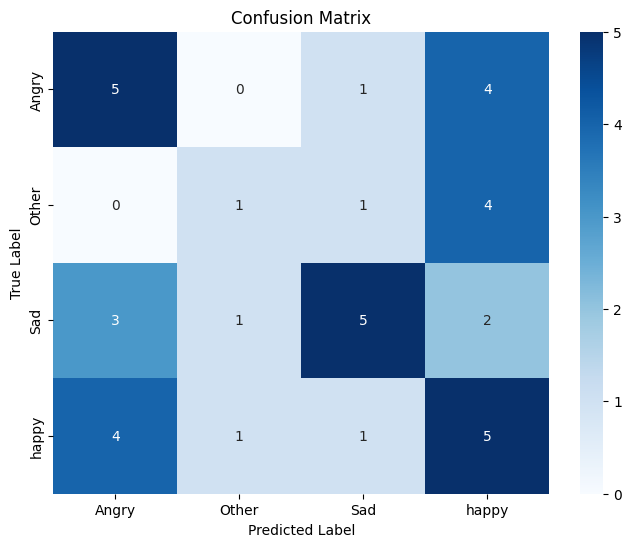

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
